In [94]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Если переменная BASE_DIR не определена, то устанавливаем её как текущий каталог
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [95]:
# Если текущий каталог является BASE_DIR, то переходим на уровень выше
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

# Определяем путь к каталогу с данными
dirname = os.path.abspath(os.curdir) + r'\data'

# Читаем данные из CSV файла
df = pd.read_csv(path.join(os.sep, dirname, 'Annual snowfall in Chicago 1939 to 1978.csv'))

# Оставляем только колонку 'x'
df = df['x']
df.head()

0    33.9
1    31.0
2    52.5
3    29.8
4    45.2
Name: x, dtype: float64

In [96]:
df.describe()

count    40.000000
mean     41.442500
std      15.714584
min      14.300000
25%      30.700000
50%      38.000000
75%      52.275000
max      82.300000
Name: x, dtype: float64

In [97]:
# Импортируем функцию для проведения теста Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

# Функция для проведения теста Дики-Фуллера
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

        # Проводим тест Дики-Фуллера для исходных данных
Fuller('Snowfall', df)

Тест Дики-Фуллера ряда Snowfall :
Test Statistic                -5.830728e+00
p-value                        3.980943e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


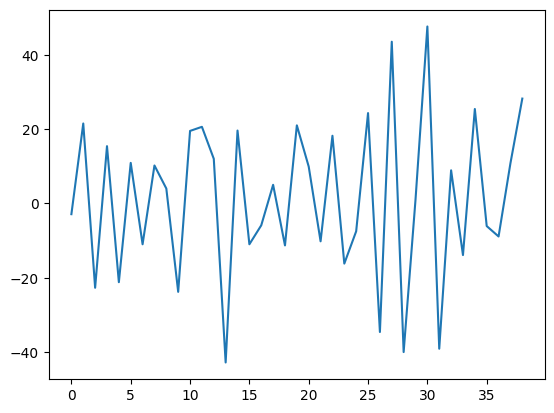

In [98]:
# Создаем выборку без тренда
nottrend = []
s = 3

# Создаем выборку без сезонности
notseason = []

# выборка без тренда
for i in range(1, len(df)):
   nottrend.append(df[i] - df[i-1])

# выборка без сезонности
for i in range(s, len(df)):
   notseason.append(df[i] - df[i-s])

   # Выводим график выборки без тренда
plt.plot(nottrend)

In [99]:
# Проводим тест Дики-Фуллера для выборки без тренда
Fuller('Non Trend Snowfall', nottrend)

Тест Дики-Фуллера ряда Non Trend Snowfall :
Test Statistic                 -4.409734
p-value                         0.000285
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


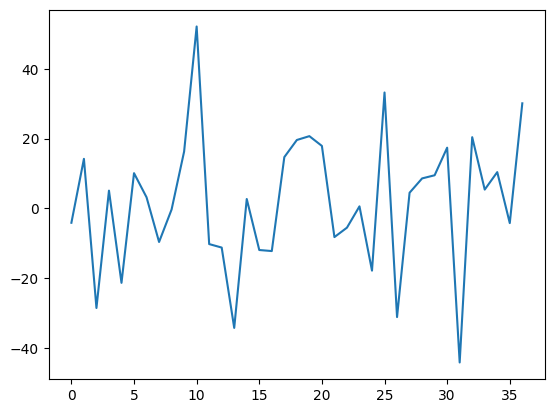

In [100]:
# Выводим график выборки без сезонности
plt.plot(notseason)

In [101]:
# Проводим тест Дики-Фуллера для выборки без сезонности
Fuller('Non Season Snowfall', notseason)

Тест Дики-Фуллера ряда Non Season Snowfall :
Test Statistic                 -3.706161
p-value                         0.004027
#Lags Used                      6.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


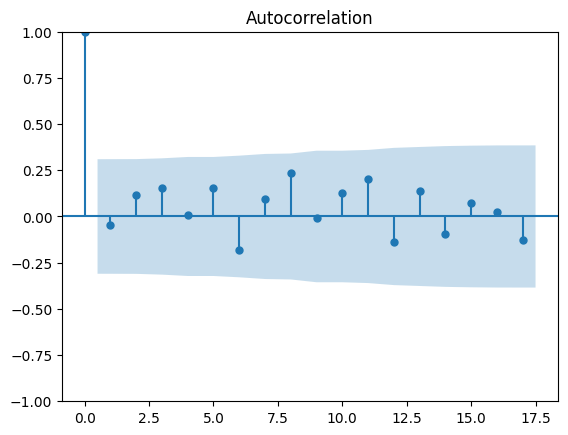

In [102]:
from statsmodels.graphics.tsaplots import plot_acf

# Автокорреляция
plot_acf(df)
plt.show()


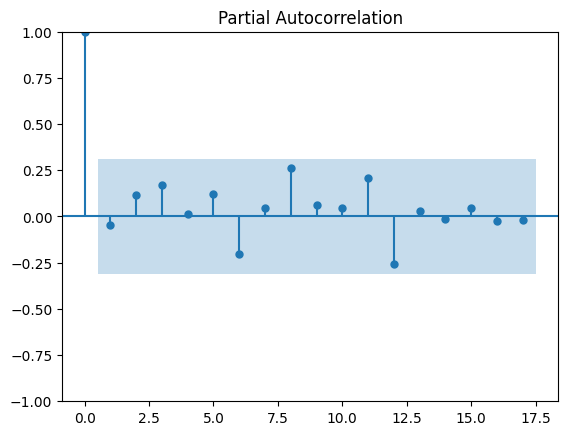

In [103]:
from statsmodels.graphics.tsaplots import plot_pacf

# Частичная автокорреляция
plot_pacf(df)
plt.show()

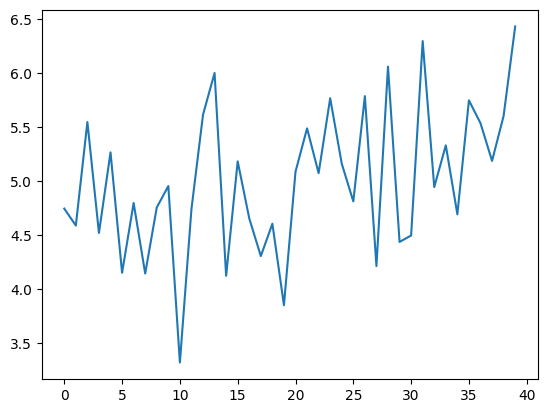

In [104]:
# Применяем преобразование Бокса-Кокса к исходным данным
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(df)

# Выводим график преобразованных данных
plt.plot(transformed_data)

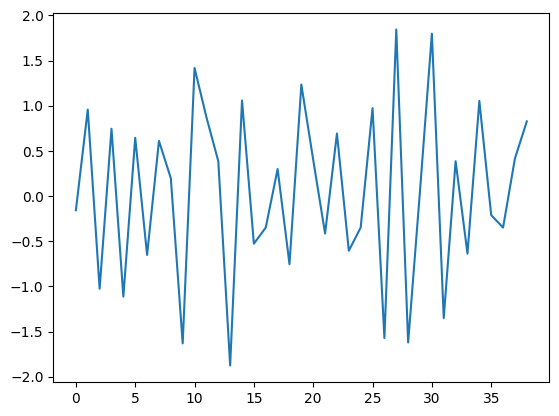

In [105]:
# Создаем выборку преобразованных данных без тренда
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])

# Выводим график выборки преобразованных данных без тренда
plt.plot(pnottrend)

In [106]:
# Проводим тест Дики-Фуллера для выборки преобразованных данных без тренда
Fuller('BoxKox Snowfall', pnottrend)

Тест Дики-Фуллера ряда BoxKox Snowfall :
Test Statistic                 -4.394145
p-value                         0.000304
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


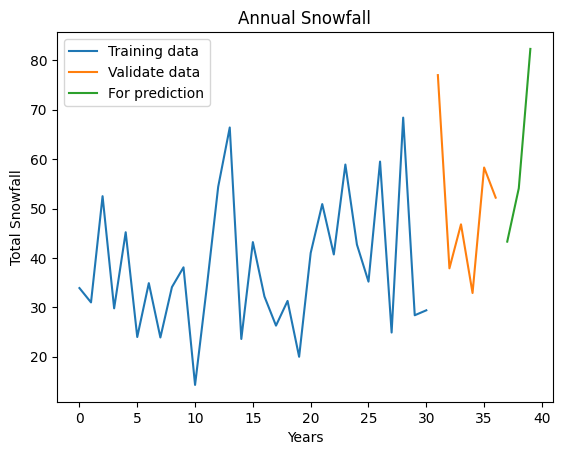

In [107]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

# Выводим график данных
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.title('Annual Snowfall')
plt.ylabel('Total Snowfall')
plt.xlabel('Years')
plt.show()

In [108]:
# Импортируем модель авторегрессии
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Обучаем модель авторегрессии
mod = AutoReg(df, 3, old_names=False)
res = mod.fit()

# Выводим результаты обучения модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   40
Model:                     AutoReg(3)   Log Likelihood                -153.630
Method:               Conditional MLE   S.D. of innovations             15.382
Date:                Sun, 10 Dec 2023   AIC                            317.260
Time:                        17:47:58   BIC                            325.315
Sample:                             3   HQIC                           320.100
                                   40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4648     13.167      2.086      0.037       1.658      53.272
x.L1          -0.0546      0.177     -0.308      0.758      -0.402       0.293
x.L2           0.1815      0.178      1.018      0.3

In [109]:
# Обучаем модель авторегрессии с другим типом ковариации
res = mod.fit(cov_type="HC0")

# Выводим результаты обучения модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   40
Model:                     AutoReg(3)   Log Likelihood                -153.630
Method:               Conditional MLE   S.D. of innovations             15.382
Date:                Sun, 10 Dec 2023   AIC                            317.260
Time:                        17:47:58   BIC                            325.315
Sample:                             3   HQIC                           320.100
                                   40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4648     12.081      2.273      0.023       3.787      51.143
x.L1          -0.0546      0.163     -0.334      0.738      -0.375       0.265
x.L2           0.1815      0.154      1.182      0.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


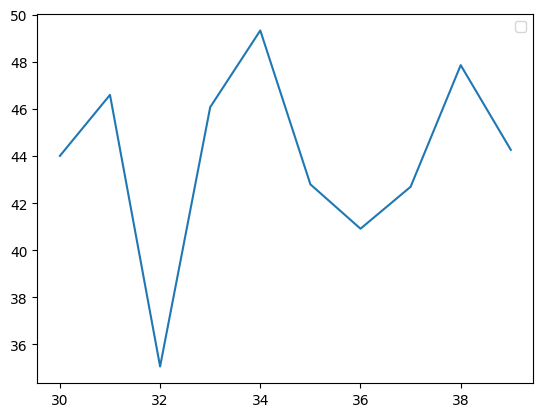

In [110]:
# Выводим график прогноза модели
fig = res.plot_predict(train_cutoff)

In [111]:
len(df)

40

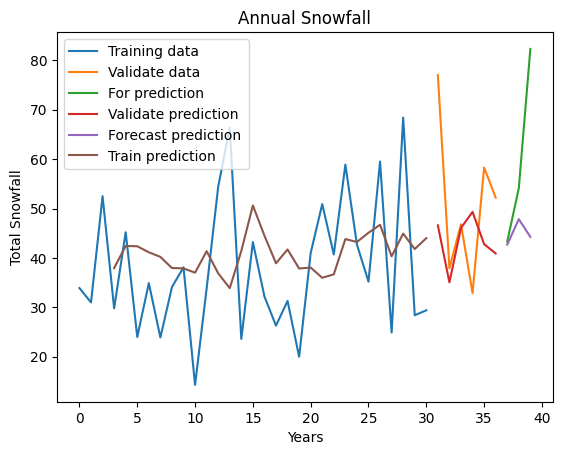

In [112]:
# Делаем прогноз на обучающей, валидационной и тестовой выборках
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(len(df)-1), dynamic=False)

# Выводим график исходных данных и прогноза
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.plot(validate_df.index, v_pred, label='Validate prediction ')
plt.plot(forecast_df.index, f_pred, label='Forecast prediction')
plt.plot(train_df.index, pred, label='Train prediction')

plt.legend()
plt.title('Annual Snowfall')
plt.ylabel('Total Snowfall')
plt.xlabel('Years')
plt.show()

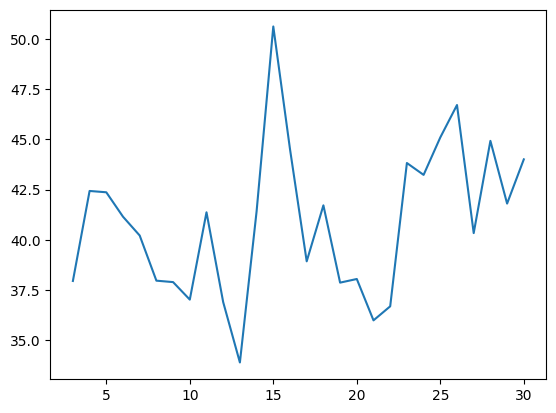

In [113]:
# Выводим график прогноза на обучающей выборке
plt.plot(pred)

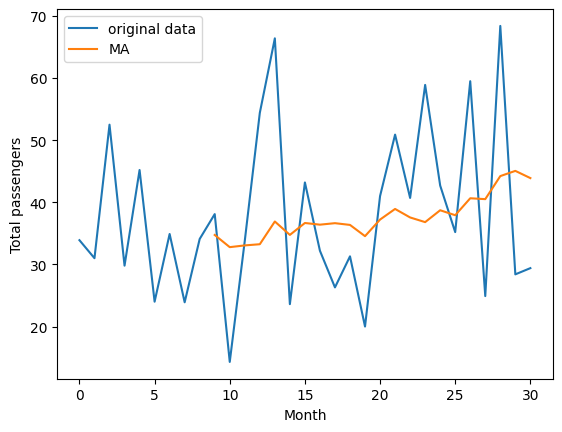

In [114]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index <= train_cutoff]
validate_df = df[(df.index > train_cutoff) & (df.index <= validate_cutoff)]
forecast_df = df[df.index > validate_cutoff]

# Выводим график исходных данных и скользящего среднего
plt.plot(train_df.index, train_df, label="original data")
plt.plot(train_df.index, train_df.rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [115]:
# Импортируем необходимые метрики из библиотеки sklearn
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [116]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [117]:
# Выводим значение RMSE (квадратный корень из среднеквадратичной ошибки)
print("RMSE:", np.sqrt(mean_squared_error(forecast_df, f_pred)))

# Выводим значение MAPE (средняя абсолютная процентная ошибка)
print("MAPE:", mean_absolute_percentage_error(forecast_df, f_pred))

# Выводим значение MAE (средняя абсолютная ошибка)
print("MAE:", mean_absolute_error(forecast_df, f_pred))

# Выводим значение R2 (коэффициент детерминации)
print("R2: ", r2_score(forecast_df, f_pred))

print("SMAPE:", smape(forecast_df, f_pred))

RMSE: 22.26052831930296
MAPE: 0.19726848453971113
MAE: 14.96651147413256
R2:  -0.833127852376772
SMAPE: 24.597488290637727


In [ ]:
# Если текущий каталог является BASE_DIR, то переходим на уровень выше
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

# Определяем путь к каталогу с данными
dirname = os.path.abspath(os.curdir) + r'\data'

# Читаем данные из CSV файла
df = pd.read_csv(path.join(os.sep, dirname, 'Annual snowfall in Chicago 1939 to 1978.csv'))

# Оставляем только колонку 'x'
df = df['x']
df.head()

In [104]:
df.describe()

count    40.000000
mean     41.442500
std      15.714584
min      14.300000
25%      30.700000
50%      38.000000
75%      52.275000
max      82.300000
Name: x, dtype: float64

In [105]:
# Импортируем функцию для проведения теста Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

# Функция для проведения теста Дики-Фуллера
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

        # Проводим тест Дики-Фуллера для исходных данных
Fuller('Snowfall', df)

Тест Дики-Фуллера ряда Snowfall :
Test Statistic                -5.830728e+00
p-value                        3.980943e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


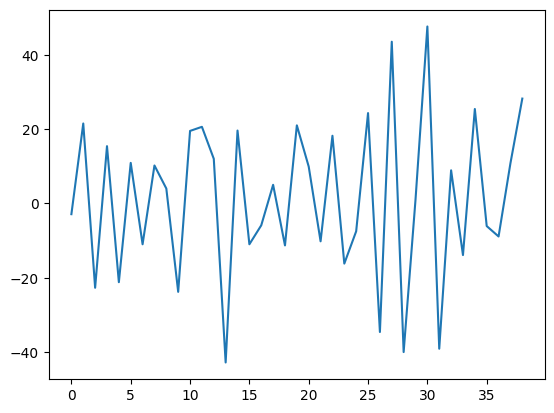

In [106]:
# Создаем выборку без тренда
nottrend = []
s = 3

# Создаем выборку без сезонности
notseason = []

# выборка без тренда
for i in range(1, len(df)):
   nottrend.append(df[i] - df[i-1])

# выборка без сезонности
for i in range(s, len(df)):
   notseason.append(df[i] - df[i-s])

   # Выводим график выборки без тренда
plt.plot(nottrend)

In [107]:
# Проводим тест Дики-Фуллера для выборки без тренда
Fuller('Non Trend Snowfall', nottrend)

Тест Дики-Фуллера ряда Non Trend Snowfall :
Test Statistic                 -4.409734
p-value                         0.000285
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


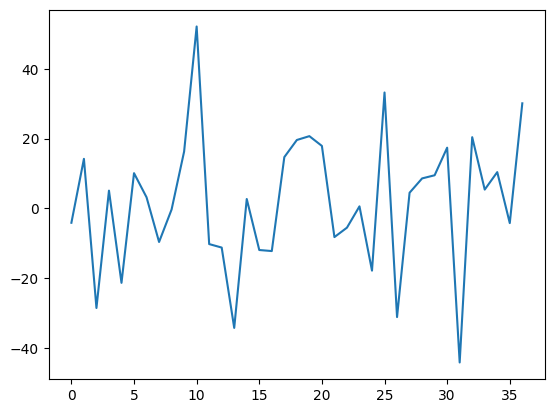

In [108]:
# Выводим график выборки без сезонности
plt.plot(notseason)

In [109]:
# Проводим тест Дики-Фуллера для выборки без сезонности
Fuller('Non Season Snowfall', notseason)

Тест Дики-Фуллера ряда Non Season Snowfall :
Test Statistic                 -3.706161
p-value                         0.004027
#Lags Used                      6.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


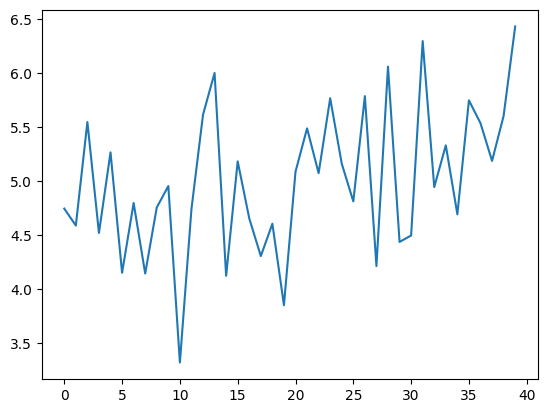

In [110]:
# Применяем преобразование Бокса-Кокса к исходным данным
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(df)

# Выводим график преобразованных данных
plt.plot(transformed_data)

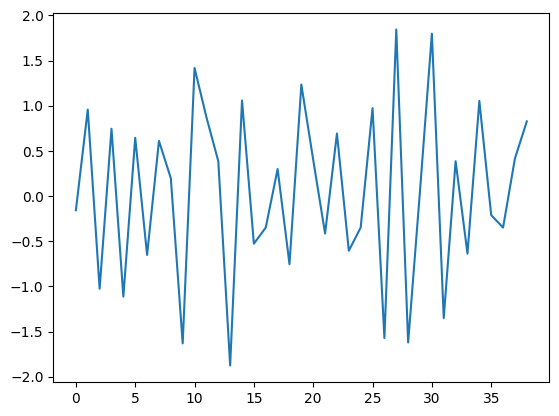

In [111]:
# Создаем выборку преобразованных данных без тренда
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])

# Выводим график выборки преобразованных данных без тренда
plt.plot(pnottrend)

In [112]:
# Проводим тест Дики-Фуллера для выборки преобразованных данных без тренда
Fuller('BoxKox Snowfall', pnottrend)

Тест Дики-Фуллера ряда BoxKox Snowfall :
Test Statistic                 -4.394145
p-value                         0.000304
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


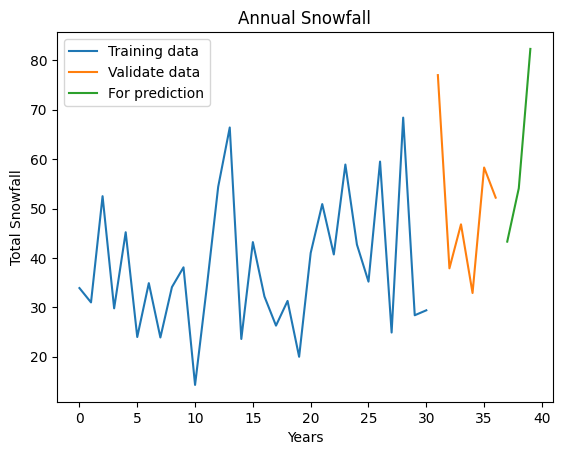

In [113]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

# Выводим график данных
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.title('Annual Snowfall')
plt.ylabel('Total Snowfall')
plt.xlabel('Years')
plt.show()

In [114]:
# Импортируем модель авторегрессии
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Обучаем модель авторегрессии
mod = AutoReg(df, 3, old_names=False)
res = mod.fit()

# Выводим результаты обучения модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   40
Model:                     AutoReg(3)   Log Likelihood                -153.630
Method:               Conditional MLE   S.D. of innovations             15.382
Date:                Sun, 10 Dec 2023   AIC                            317.260
Time:                        17:28:41   BIC                            325.315
Sample:                             3   HQIC                           320.100
                                   40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4648     13.167      2.086      0.037       1.658      53.272
x.L1          -0.0546      0.177     -0.308      0.758      -0.402       0.293
x.L2           0.1815      0.178      1.018      0.3

In [115]:
# Обучаем модель авторегрессии с другим типом ковариации
res = mod.fit(cov_type="HC0")

# Выводим результаты обучения модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   40
Model:                     AutoReg(3)   Log Likelihood                -153.630
Method:               Conditional MLE   S.D. of innovations             15.382
Date:                Sun, 10 Dec 2023   AIC                            317.260
Time:                        17:28:41   BIC                            325.315
Sample:                             3   HQIC                           320.100
                                   40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4648     12.081      2.273      0.023       3.787      51.143
x.L1          -0.0546      0.163     -0.334      0.738      -0.375       0.265
x.L2           0.1815      0.154      1.182      0.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


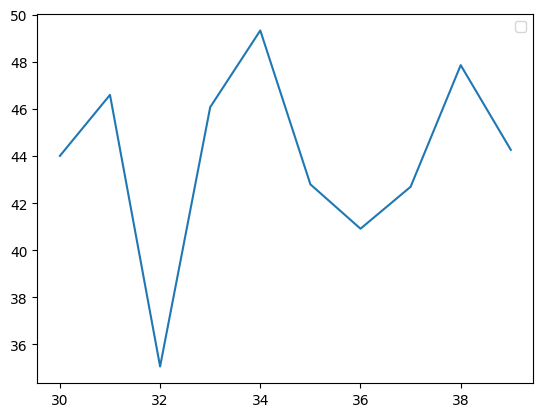

In [116]:
# Выводим график прогноза модели
fig = res.plot_predict(train_cutoff)

In [117]:
len(df)

40

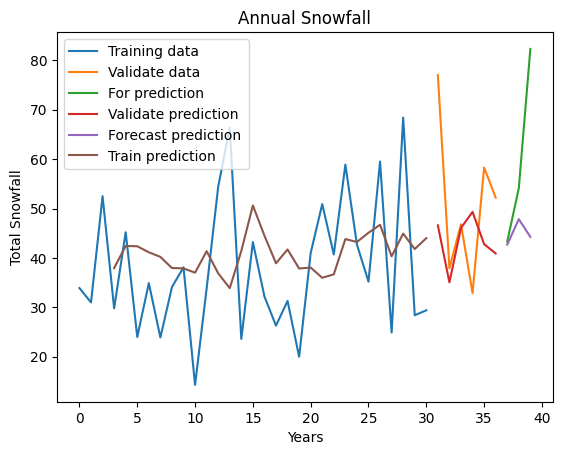

In [118]:
# Делаем прогноз на обучающей, валидационной и тестовой выборках
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(len(df)-1), dynamic=False)

# Выводим график исходных данных и прогноза
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.plot(validate_df.index, v_pred, label='Validate prediction ')
plt.plot(forecast_df.index, f_pred, label='Forecast prediction')
plt.plot(train_df.index, pred, label='Train prediction')

plt.legend()
plt.title('Annual Snowfall')
plt.ylabel('Total Snowfall')
plt.xlabel('Years')
plt.show()

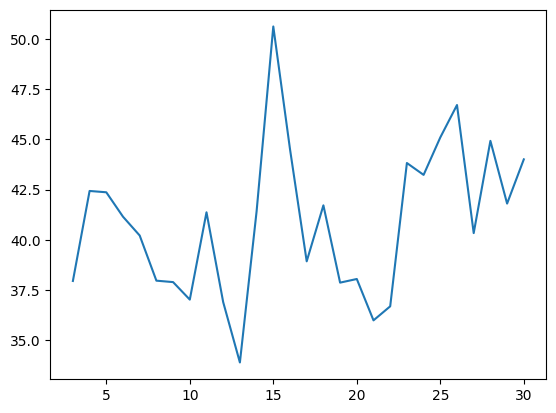

In [119]:
# Выводим график прогноза на обучающей выборке
plt.plot(pred)

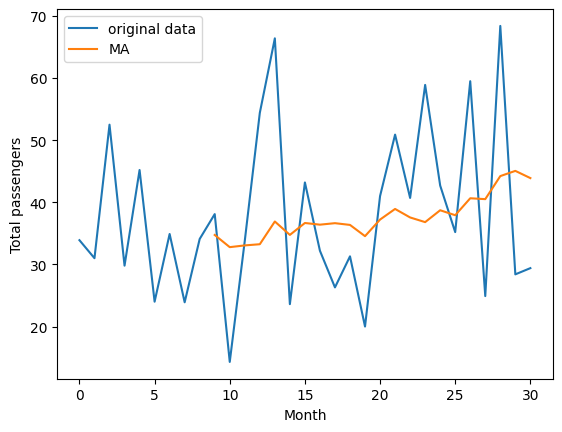

In [120]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index <= train_cutoff]
validate_df = df[(df.index > train_cutoff) & (df.index <= validate_cutoff)]
forecast_df = df[df.index > validate_cutoff]

# Выводим график исходных данных и скользящего среднего
plt.plot(train_df.index, train_df, label="original data")
plt.plot(train_df.index, train_df.rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [121]:
# Импортируем необходимые метрики из библиотеки sklearn
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [122]:
# Выводим значение RMSE (квадратный корень из среднеквадратичной ошибки)
print("RMSE:", np.sqrt(mean_squared_error(forecast_df, f_pred)))

# Выводим значение MAPE (средняя абсолютная процентная ошибка)
print("MAPE:", mean_absolute_percentage_error(forecast_df, f_pred))

# Выводим значение MAE (средняя абсолютная ошибка)
print("MAE:", mean_absolute_error(forecast_df, f_pred))

# Выводим значение R2 (коэффициент детерминации)
print("R2: ", r2_score(forecast_df, f_pred))

RMSE: 22.26052831930296
MAPE: 0.19726848453971113
MAE: 14.96651147413256
R2:  -0.833127852376772
